In [36]:
# Import statements
import numpy as np
import torch
import plotly.express as px
import matplotlib.pyplot as plt
import math
import pandas as pd

## Analyzing Characteristics of Author's Proposed Activation Function (SiLU)

Text(0.5, 1.0, 'SiLU with Beta Value of 1')

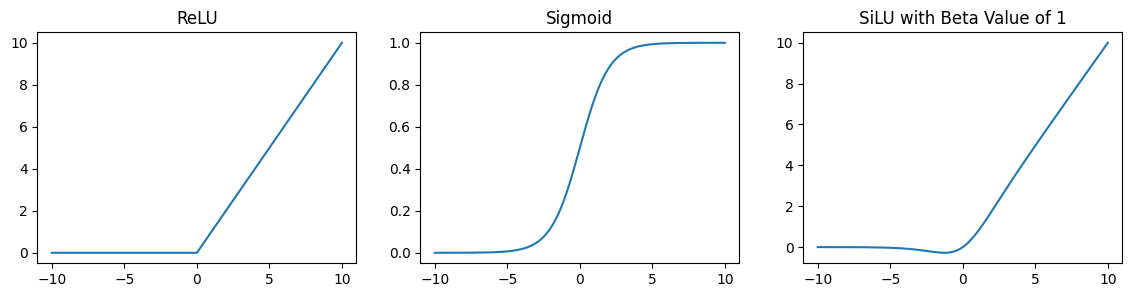

In [37]:
# Create a plot of the regular sigmoid function

# Define the sigmoid equation
def sigmoid(x):

  # Return the function
  return 1 / (1 + math.e**(-x))

# Define sigmoid with beta constant value
def sigmoid_beta(x, beta_value):

  # Return the function
  return 1 / (1 + math.e**(-x * beta_value))

# Define SiLU/Swish function, that the authors propose in the paper
def swish(x, beta_value):

  # Return the function
  return x * (1 / (1 + math.e**(-x * beta_value)))

# Define relu function
def relu(x):
  # If logic for relu
  if (x > 0):
    return x
  else:
    return 0


# Create x data for the functions
x_data = np.linspace(-10,10,500)

# Initialize y arrays
y_data_sigmoid = []
y_data_sigmoid_beta = []
y_data_swish = []
y_data_relu = []
y_data_swish_half_beta = []

# Beta value for changing
beta_value_input = 1

# Iterate through the x data to create y for each function
for item in x_data:

  # Append to each array
  y_data_relu.append(relu(item))
  y_data_sigmoid.append(sigmoid(item))
  y_data_sigmoid_beta.append(sigmoid_beta(item, beta_value_input))
  y_data_swish.append(swish(item,beta_value_input))
  y_data_swish_half_beta.append(swish(item, 0.25))


# Plot data
fig, ax = plt.subplots(1,3, figsize = (14,3))

# Make the plots
ax[0].plot(x_data, y_data_relu)
ax[0].set_title("ReLU")
ax[1].plot(x_data,y_data_sigmoid)
ax[1].set_title("Sigmoid")
ax[2].plot(x_data,y_data_swish)
ax[2].set_title("SiLU with Beta Value of " + str(beta_value_input))



Text(0.5, 1.0, 'Difference Between Swish and Relu Derivative, using Beta Value of 1')

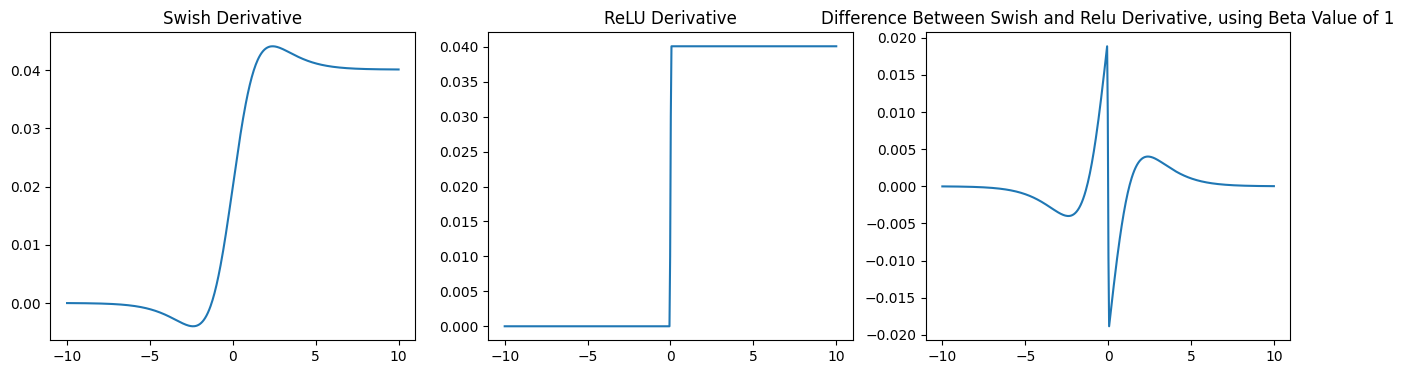

In [113]:
# Derivative plots

# Get derivative of SiLU
y_data_swish_derivative = np.gradient(y_data_swish)
y_data_relu_derivative = np.gradient(y_data_relu)
swish_relu_difference = np.array(y_data_swish_derivative) - np.array(y_data_relu_derivative)

# Plot derivative
fig, ax = plt.subplots(1,3, figsize = (16,4))
ax[0].plot(x_data, y_data_swish_derivative)
ax[0].set_title("SiLU Derivative")
ax[1].plot(x_data, y_data_relu_derivative)
ax[1].set_title("ReLU Derivative")
ax[2].plot(x_data, swish_relu_difference)
ax[2].set_title("Difference Between SiLU and Relu Derivative, using Beta Value of " + str(beta_value_input ))


Observations:
- SiLU and Relu primarily have differences at values close to 0, when beta is larger than 1. Using larger beta values condenses the differences to a smaller range centered at 0
- Using beta values less than 1 expands the range of the differences.
- Larger beta values may be better suited for models that have many values closer to 0
- Smaller beta values may be better for networks with different ranges

## Analyzing Results from Network Training - Fashion MNIST

We began our work by comparing two models trained on the Fashion MNIST dataset from PyTorch. For the model, we used a fully connected network with 3 linear layers. To compare ReLU to SiLU, we simply changed every activation function call from ReLU to the corresponding pytorch SiLU call (nn.SiLU). We kept all other aspects of the network the same.

In [39]:
# Function for loading in results and producing graph
def graph_datasets(dataset_list, function_labels):

  # Create the subplot object
  fig, ax = plt.subplots(1,3, figsize = (16,4))

  # Iterate through the subplot
  for index, current in enumerate(dataset_list):

    # Plot the test accuracy
    ax[0].plot(current["epochs"],current["test_acc"],label = function_labels[index])
    ax[0].set_title("Accuracy Comparison")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")
    ax[0].legend()

    # Plot the training loss
    ax[1].plot(current["epochs"],current["train loss"], label = function_labels[index])
    ax[1].set_title("Training Loss Comparison")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training Loss")
    ax[1].legend()

    # Plot the test loss
    ax[2].plot(current["epochs"],current["test_loss"], label = function_labels[index])
    ax[2].set_title("Test Loss Comparison")
    ax[2].set_xlabel("Epochs")
    ax[2].set_ylabel("Test Loss")
    ax[2].legend()

  # Show the results
  fig.show()

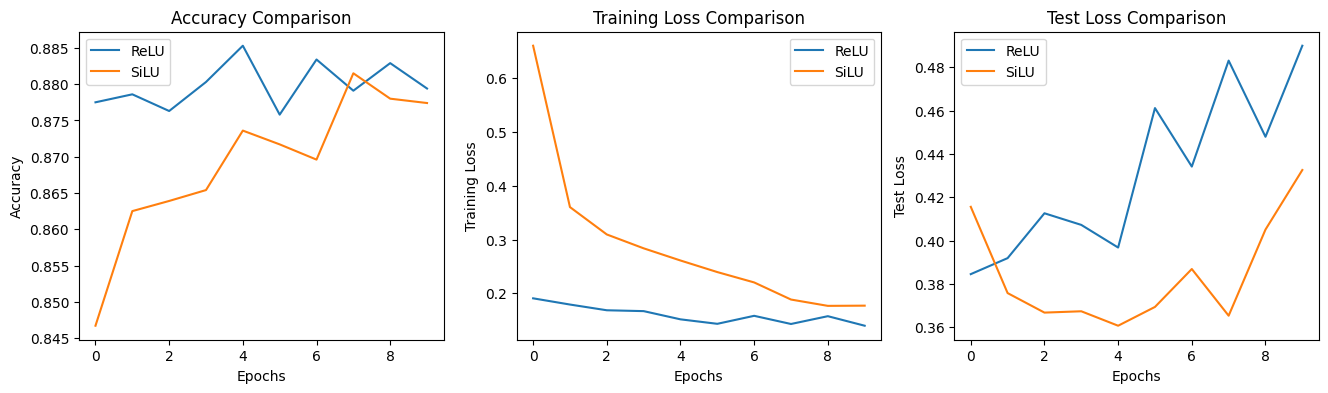

In [40]:
# Load the results as csv
fcnet_relu = pd.read_csv("fcnet_relu.csv").rename(columns={"Unnamed: 0":"epochs"})
fcnet_silu = pd.read_csv("fcnet_silu.csv").rename(columns={"Unnamed: 0":"epochs"})

# Plot graphs
graph_datasets([fcnet_relu, fcnet_silu],["ReLU", "SiLU"])

Interestingly, for almost every epoch, ReLU has a better accuracy than SiLU. ReLU also always has a better training loss than SiLU. However, this is where the similarities end. SiLU seems to generalize slightly better than ReLU, as shown by the test loss graph. For every iteration after the initial, SiLU's test loss is lower than ReLU, although both start to increase after about 7 epochs.

## Analyzing Results from Network Training: Resnet on CIFAR10

###ResNet with 20 Layers

In [41]:
# Function to load in datasets with varying names
def load_datasets(network_type, layers, activation_functions):

  # Initialize final list of datasets
  final_datasets = []

  # Iterate through each activation function
  for name in activation_functions:
    # Create the name
    final_name = network_type + "_" + str(layers) + "_" + name + ".csv"

    # Load in the dataset
    current_dataset = pd.read_csv(final_name).rename(columns={"Unnamed: 0":"epochs"})

    # Add to the list of datasets
    final_datasets.append(current_dataset)

  # Return the set of datasets
  return final_datasets


In [42]:
# Function to compare final results in a dataframe/tabular format
def compare_results(datasets, activation_list):

  # Initialize dataframe
  final_df = pd.DataFrame(columns = ["Activation Function","Accuracy","Train Loss","Test Loss"])

  # Iterate through the datasets
  for index,x in enumerate(zip(datasets,activation_list)):

    # Set the activation variable
    activation = x[1]
    current_data = x[0]

    # Get the current end value for the current activation function
    current_end_value = current_data[current_data["epochs"] == 9].squeeze().to_list()

    # Set the row of the final df
    final_df.loc[index] = [activation,current_end_value[2],current_end_value[1],current_end_value[3]]

  # Returns the final df
  return final_df

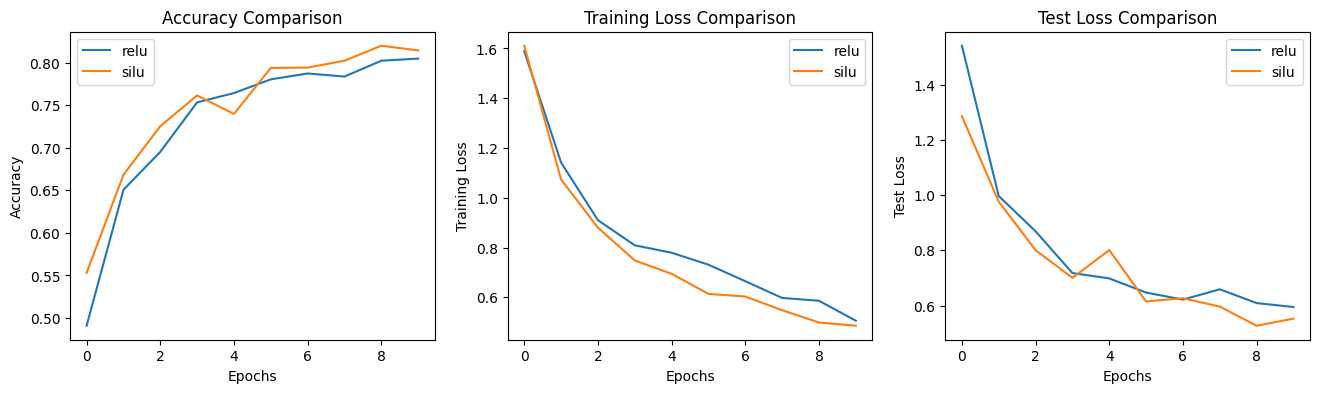

In [43]:
# 20 Layer ResNet on CIFAR 10 - Relu and Silu
current_activations = ["relu","silu"]
dataset_list = load_datasets("resnet",20,current_activations)
graph_datasets(dataset_list,current_activations)

In [44]:
# Compare results
compare_results(dataset_list,current_activations)

,Activation Function,Accuracy,Train Loss,Test Loss
0,relu,0.8047,0.505950,0.595131
1,silu,0.8143,0.485753,0.553022


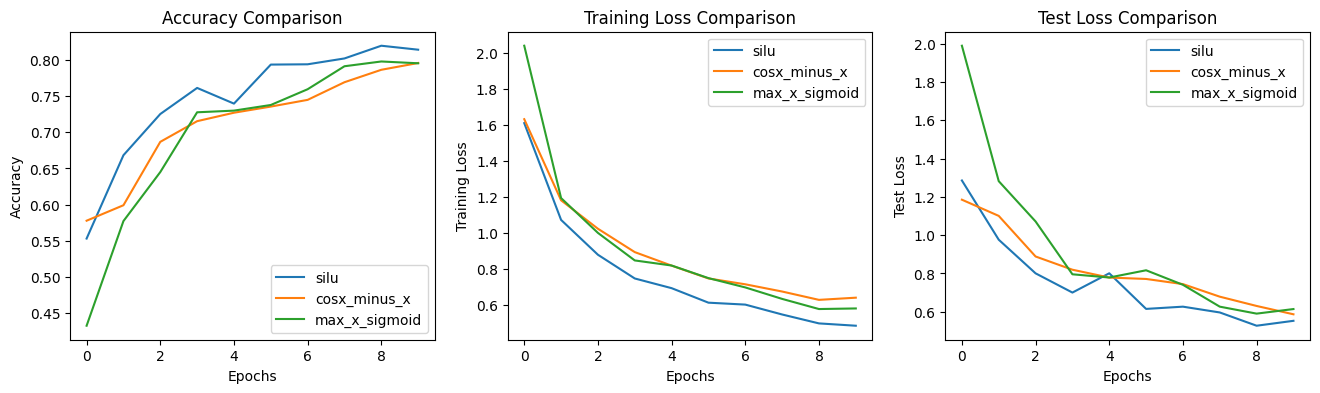

In [45]:
# 20 Layer ResNet on CIFAR 10 - Author's functions
current_activations = ["silu","cosx_minus_x","max_x_sigmoid"]
dataset_list = load_datasets("resnet",20,current_activations)
graph_datasets(dataset_list,current_activations)

In [46]:
# Compare results
compare_results(dataset_list,current_activations)

,Activation Function,Accuracy,Train Loss,Test Loss
0,silu,0.8143,0.485753,0.553022
1,cosx_minus_x,0.7959,0.641438,0.587057
2,max_x_sigmoid,0.7955,0.581675,0.614394


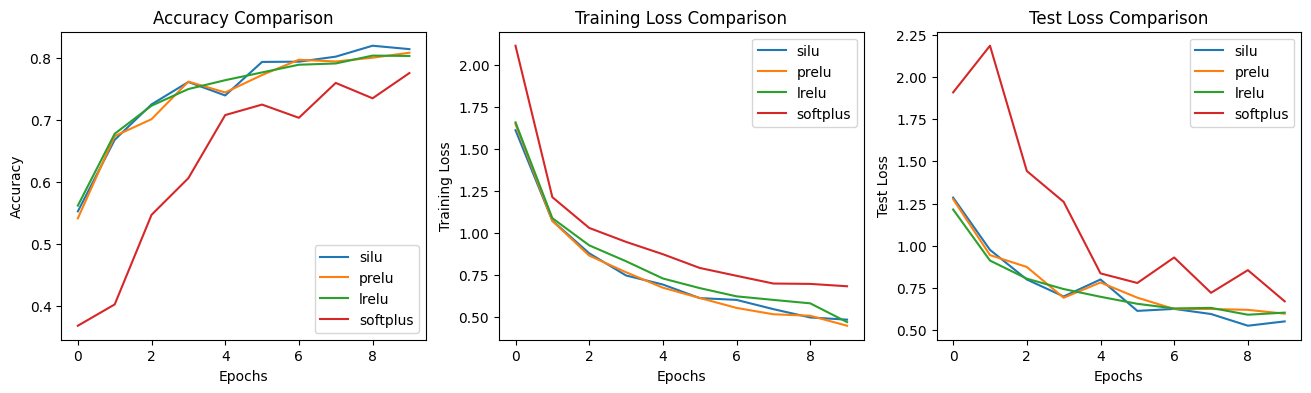

In [47]:
# 20 Layer ResNet on CIFAR 10
current_activations = ["silu","prelu","lrelu","softplus"]
dataset_list = load_datasets("resnet",20,current_activations)
graph_datasets(dataset_list,current_activations)

In [48]:
# Compare results
compare_results(dataset_list,current_activations)

,Activation Function,Accuracy,Train Loss,Test Loss
0,silu,0.8143,0.485753,0.553022
1,prelu,0.8085,0.449701,0.598796
2,lrelu,0.8033,0.471236,0.604913
3,softplus,0.7758,0.683996,0.671707


In [49]:
# Full results
current_activations = ["relu","silu","cosx_minus_x","max_x_sigmoid","prelu","lrelu","softplus"]
current_datasets = load_datasets("resnet",20,current_activations)
compare_results(current_datasets, current_activations)

,Activation Function,Accuracy,Train Loss,Test Loss
0,relu,0.8047,0.505950,0.595131
1,silu,0.8143,0.485753,0.553022
2,cosx_minus_x,0.7959,0.641438,0.587057
3,max_x_sigmoid,0.7955,0.581675,0.614394
4,prelu,0.8085,0.449701,0.598796
5,lrelu,0.8033,0.471236,0.604913
6,softplus,0.7758,0.683996,0.671707


###ResNet with 32 Layers

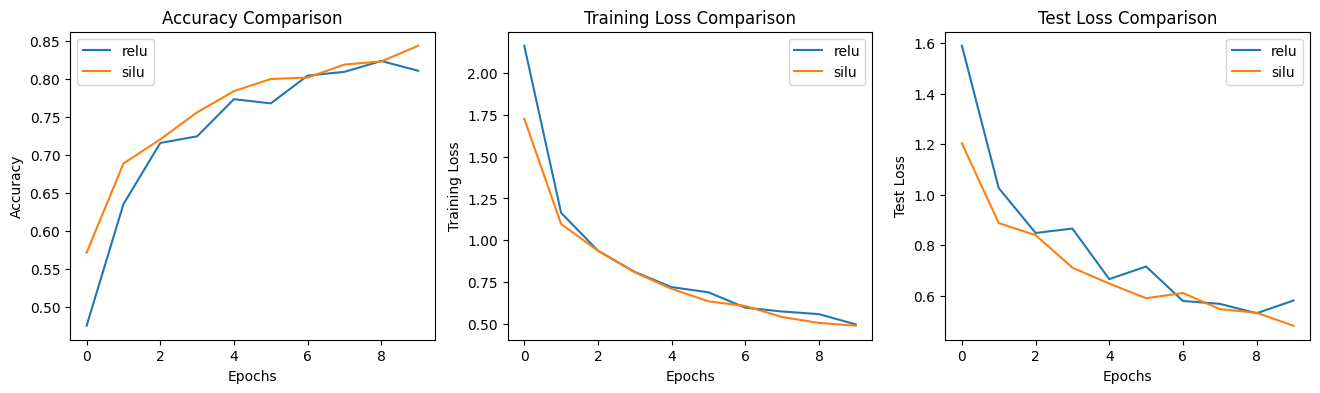

In [50]:
# 32 Layer ResNet on CIFAR 10 - Relu and Silu
current_activations = ["relu","silu"]
dataset_list = load_datasets("resnet",32,current_activations)
graph_datasets(dataset_list,current_activations)

In [51]:
# Compare results
compare_results(dataset_list,current_activations)

,Activation Function,Accuracy,Train Loss,Test Loss
0,relu,0.8109,0.494710,0.580548
1,silu,0.8438,0.486876,0.480673


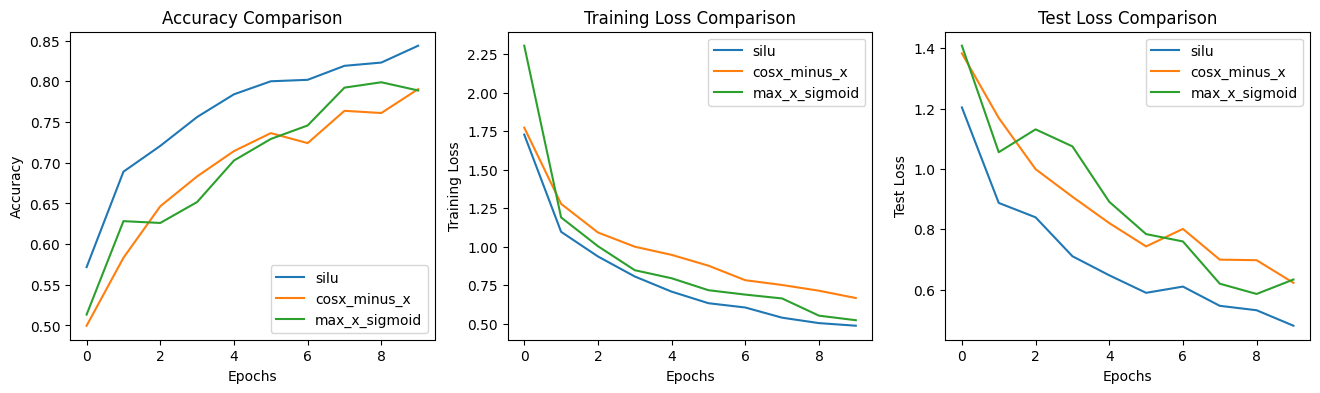

In [52]:
# 32 Layer ResNet on CIFAR 10 - Author's functions
current_activations = ["silu","cosx_minus_x","max_x_sigmoid"]
dataset_list = load_datasets("resnet",32,current_activations)
graph_datasets(dataset_list,current_activations)

In [53]:
# Compare results
compare_results(dataset_list,current_activations)

,Activation Function,Accuracy,Train Loss,Test Loss
0,silu,0.8438,0.486876,0.480673
1,cosx_minus_x,0.7905,0.666707,0.622703
2,max_x_sigmoid,0.7888,0.522662,0.633710


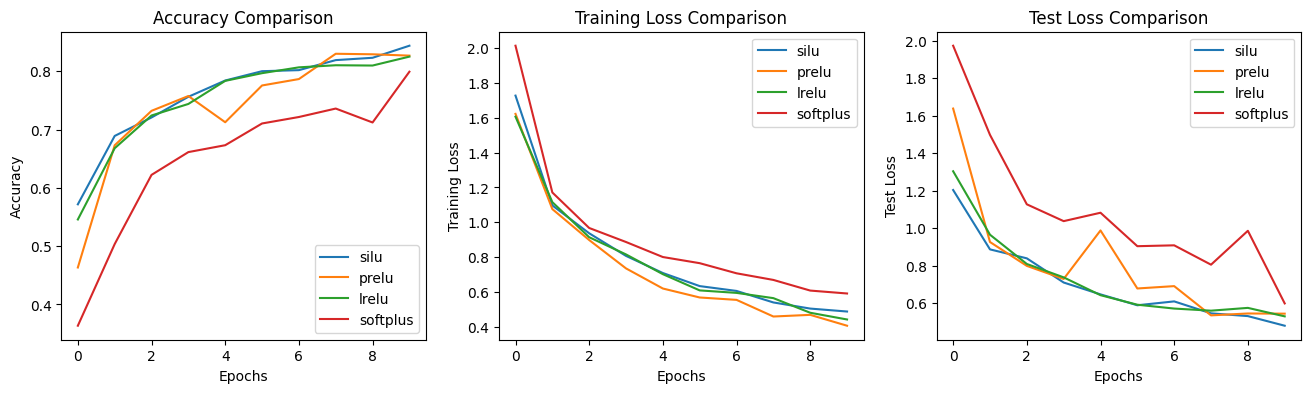

In [54]:
# 32 Layer ResNet on CIFAR 10
current_activations = ["silu","prelu","lrelu","softplus"]
dataset_list = load_datasets("resnet",32,current_activations)
graph_datasets(dataset_list,current_activations)

In [55]:
# Compare results
compare_results(dataset_list,current_activations)

,Activation Function,Accuracy,Train Loss,Test Loss
0,silu,0.8438,0.486876,0.480673
1,prelu,0.8268,0.405251,0.544942
2,lrelu,0.8251,0.441131,0.530557
3,softplus,0.7992,0.590540,0.599507


In [56]:
# Full results
current_activations = ["relu","silu","cosx_minus_x","max_x_sigmoid","prelu","lrelu","softplus"]
current_datasets = load_datasets("resnet",32,current_activations)
compare_results(current_datasets, current_activations)

,Activation Function,Accuracy,Train Loss,Test Loss
0,relu,0.8109,0.494710,0.580548
1,silu,0.8438,0.486876,0.480673
2,cosx_minus_x,0.7905,0.666707,0.622703
3,max_x_sigmoid,0.7888,0.522662,0.633710
4,prelu,0.8268,0.405251,0.544942
5,lrelu,0.8251,0.441131,0.530557
6,softplus,0.7992,0.590540,0.599507


### ResNet with 44 Layers

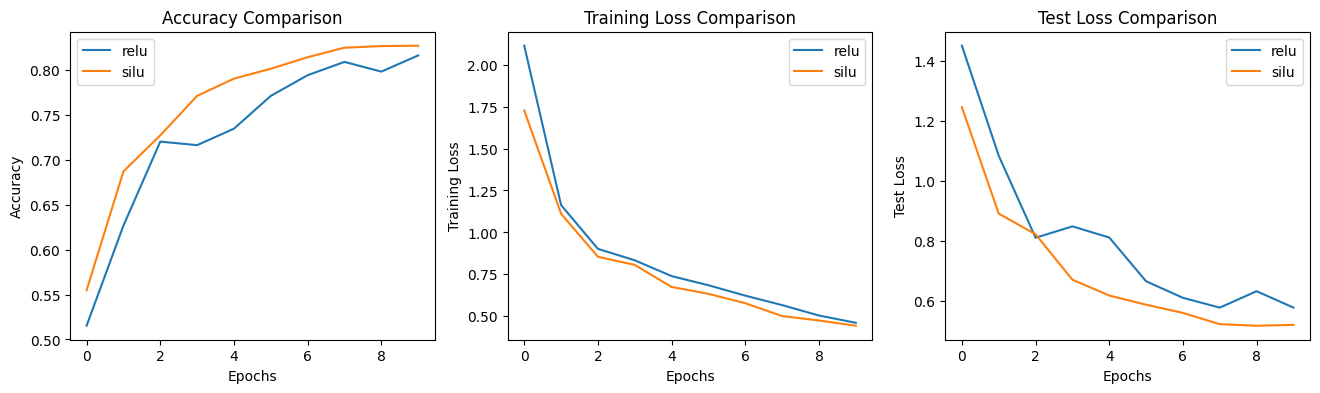

In [57]:
# 44 Layer ResNet on CIFAR 10 - Relu and Silu
current_activations = ["relu","silu"]
dataset_list = load_datasets("resnet",44,current_activations)
graph_datasets(dataset_list,current_activations)

In [58]:
# Compare results
compare_results(dataset_list,current_activations)

,Activation Function,Accuracy,Train Loss,Test Loss
0,relu,0.8160,0.461315,0.578161
1,silu,0.8268,0.443869,0.520646


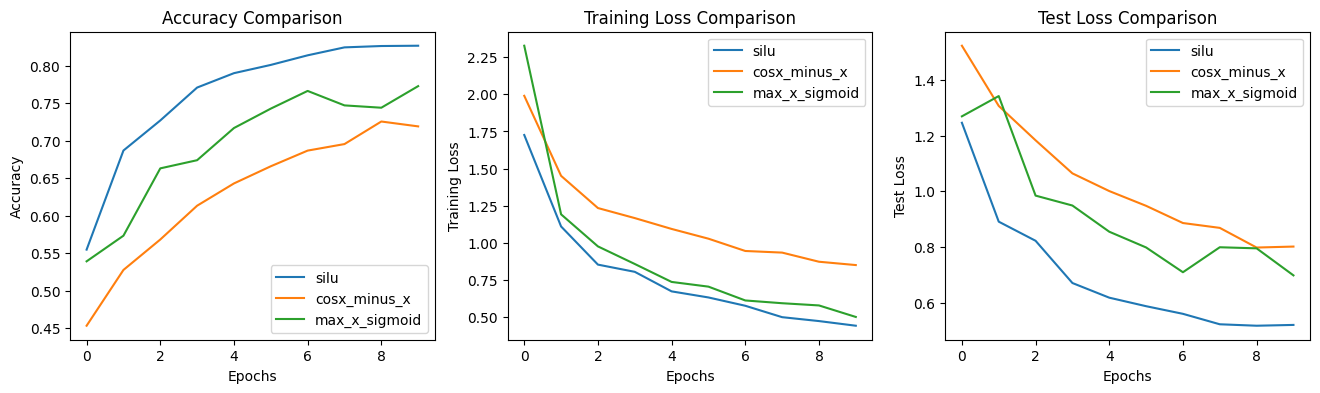

In [59]:
# 44 Layer ResNet on CIFAR 10 - Author's functions
current_activations = ["silu","cosx_minus_x","max_x_sigmoid"]
dataset_list = load_datasets("resnet",44,current_activations)
graph_datasets(dataset_list,current_activations)

In [60]:
# Compare results
compare_results(dataset_list,current_activations)

,Activation Function,Accuracy,Train Loss,Test Loss
0,silu,0.8268,0.443869,0.520646
1,cosx_minus_x,0.7192,0.851749,0.801691
2,max_x_sigmoid,0.7729,0.502835,0.698362


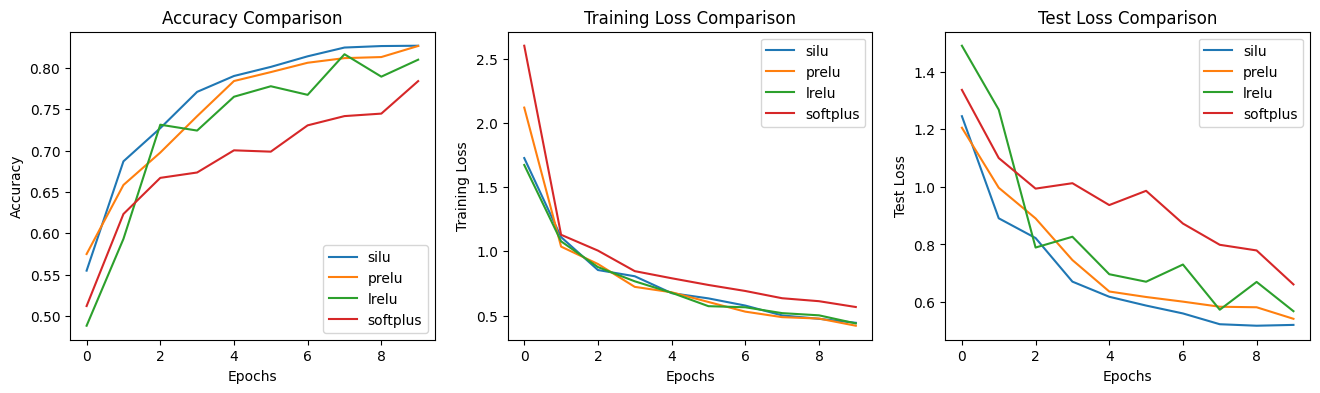

In [61]:
# 44 Layer ResNet on CIFAR 10
current_activations = ["silu","prelu","lrelu","softplus"]
dataset_list = load_datasets("resnet",44,current_activations)
graph_datasets(dataset_list,current_activations)

In [62]:
# Compare results
compare_results(dataset_list,current_activations)

,Activation Function,Accuracy,Train Loss,Test Loss
0,silu,0.8268,0.443869,0.520646
1,prelu,0.8265,0.421156,0.541808
2,lrelu,0.8099,0.439215,0.568282
3,softplus,0.7840,0.566752,0.661296


In [63]:
# Full results
current_activations = ["relu","silu","cosx_minus_x","max_x_sigmoid","prelu","lrelu","softplus"]
current_datasets = load_datasets("resnet",44,current_activations)
compare_results(current_datasets, current_activations)

,Activation Function,Accuracy,Train Loss,Test Loss
0,relu,0.8160,0.461315,0.578161
1,silu,0.8268,0.443869,0.520646
2,cosx_minus_x,0.7192,0.851749,0.801691
3,max_x_sigmoid,0.7729,0.502835,0.698362
4,prelu,0.8265,0.421156,0.541808
5,lrelu,0.8099,0.439215,0.568282
6,softplus,0.7840,0.566752,0.661296


###ResNet with 56 Layers

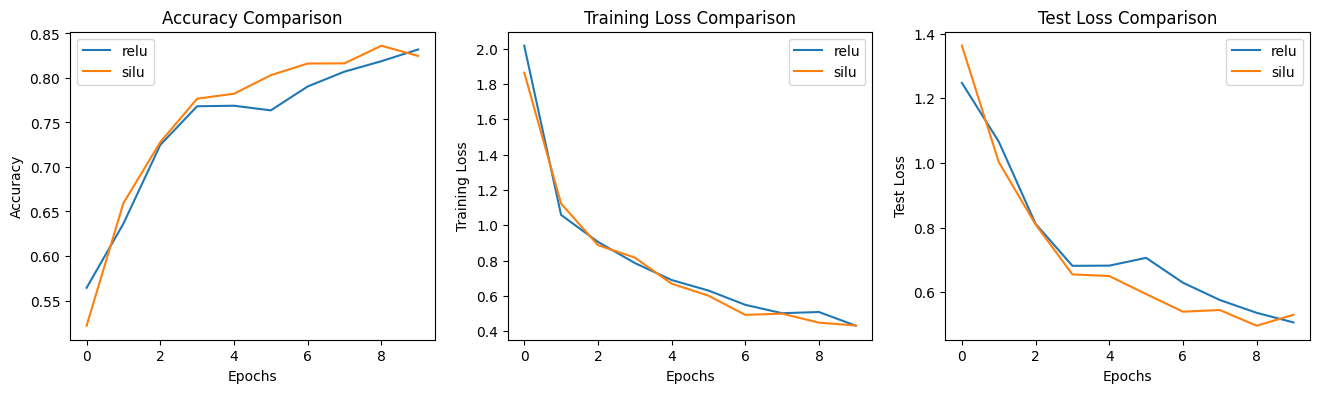

In [64]:
# 56 Layer ResNet on CIFAR 10 - Relu and Silu
current_activations = ["relu","silu"]
dataset_list = load_datasets("resnet",56,current_activations)
graph_datasets(dataset_list,current_activations)

In [65]:
# Compare results
compare_results(dataset_list,current_activations)

,Activation Function,Accuracy,Train Loss,Test Loss
0,relu,0.8320,0.431940,0.507002
1,silu,0.8247,0.433171,0.530557


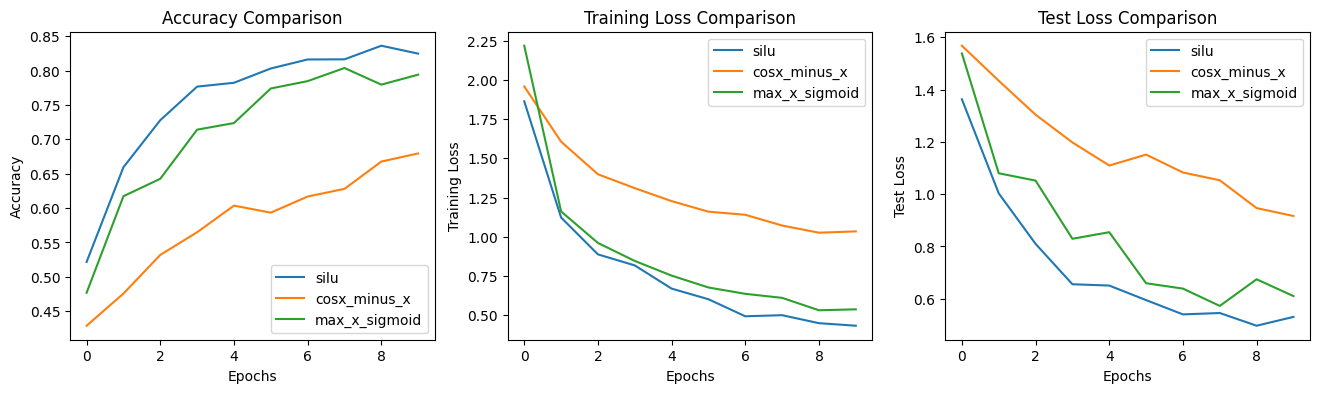

In [66]:
# 56 Layer ResNet on CIFAR 10 - Author's functions
current_activations = ["silu","cosx_minus_x","max_x_sigmoid"]
dataset_list = load_datasets("resnet",56,current_activations)
graph_datasets(dataset_list,current_activations)

In [67]:
# Compare results
compare_results(dataset_list,current_activations)

,Activation Function,Accuracy,Train Loss,Test Loss
0,silu,0.8247,0.433171,0.530557
1,cosx_minus_x,0.6795,1.034555,0.916544
2,max_x_sigmoid,0.7941,0.537721,0.610141


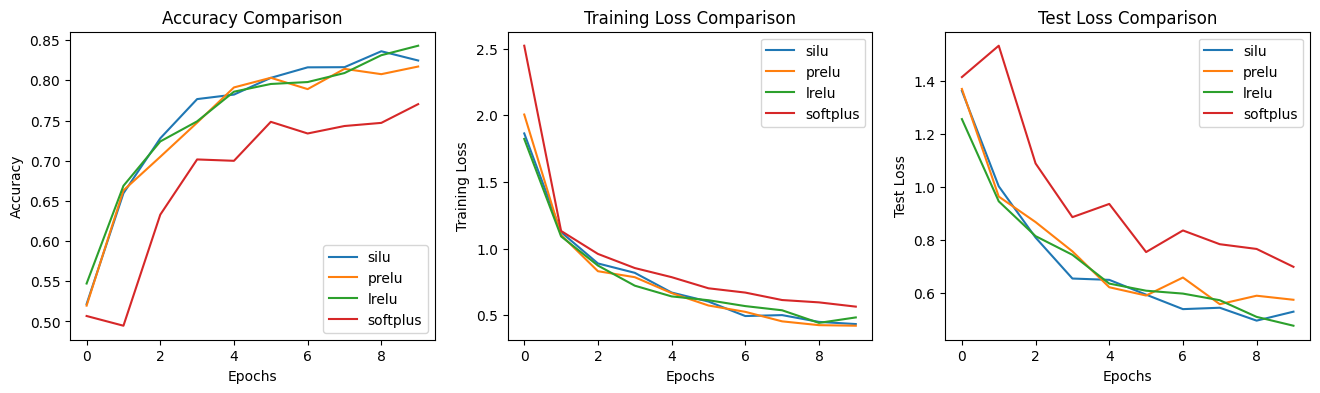

In [68]:
# 56 Layer ResNet on CIFAR 10
current_activations = ["silu","prelu","lrelu","softplus"]
dataset_list = load_datasets("resnet",56,current_activations)
graph_datasets(dataset_list,current_activations)

In [69]:
# Compare results
compare_results(dataset_list,current_activations)

,Activation Function,Accuracy,Train Loss,Test Loss
0,silu,0.8247,0.433171,0.530557
1,prelu,0.8172,0.420690,0.575395
2,lrelu,0.8431,0.482940,0.477587
3,softplus,0.7704,0.563927,0.699542


In [70]:
# Full results
current_activations = ["relu","silu","cosx_minus_x","max_x_sigmoid","prelu","lrelu","softplus"]
current_datasets = load_datasets("resnet",56,current_activations)
compare_results(current_datasets, current_activations)

,Activation Function,Accuracy,Train Loss,Test Loss
0,relu,0.8320,0.431940,0.507002
1,silu,0.8247,0.433171,0.530557
2,cosx_minus_x,0.6795,1.034555,0.916544
3,max_x_sigmoid,0.7941,0.537721,0.610141
4,prelu,0.8172,0.420690,0.575395
5,lrelu,0.8431,0.482940,0.477587
6,softplus,0.7704,0.563927,0.699542


##Analyze Runtimes

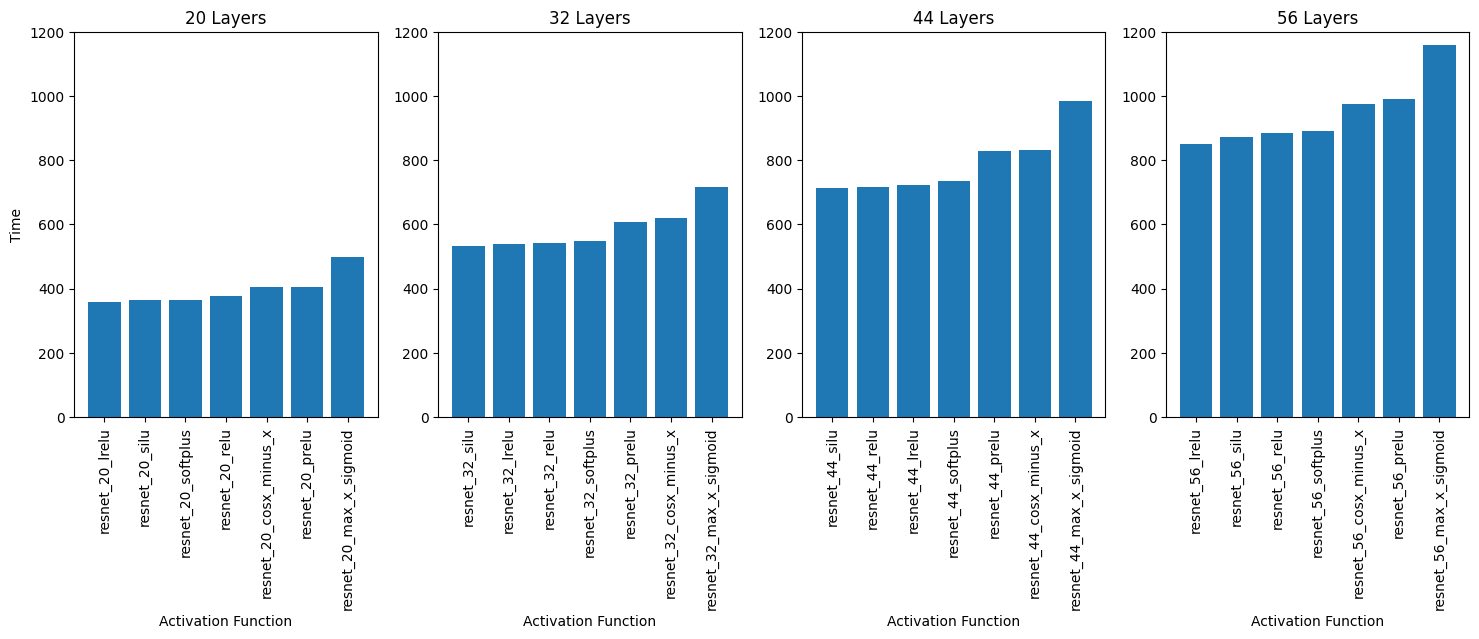

In [110]:
# Load in runtime data
times = pd.read_csv("times.csv").drop(columns = ["Unnamed: 0"]).sort_values("model")

# Separate the models based on their number of layers, and sort based on runtime
times_20 = times[0:7].sort_values("time")
times_32 = times[7:14].sort_values("time")
times_44 = times[14:21].sort_values("time")
times_56 = times[21:28].sort_values("time")

# Create a subplot
fig, ax = plt.subplots(1,4, figsize = (18,5))

# Set first plot to a bar graph and set attributes
ax[0].bar(times_20["model"], times_20["time"])
ax[0].set_ylim([0,1200])
ax[0].set_title("20 Layers")
ax[0].set_xlabel("Activation Function")
ax[0].set_ylabel("Time")
ax[0].tick_params(axis='x',rotation=90)

# Set second plot to a bar graph and set attributes
ax[1].bar(times_32["model"],times_32["time"])
ax[1].set_ylim([0,1200])
ax[1].set_title("32 Layers")
ax[1].set_xlabel("Activation Function")
ax[1].tick_params(axis='x',rotation=90)

# Set third plot to a bar graph and set attributes
ax[2].bar(times_44["model"],times_44["time"])
ax[2].set_ylim([0,1200])
ax[2].set_title("44 Layers")
ax[2].set_xlabel("Activation Function")
ax[2].tick_params(axis='x',rotation=90)

# Set fourth plot to a bar graph and set attributes
ax[3].bar(times_56["model"],times_56["time"])
ax[3].set_ylim([0,1200])
ax[3].tick_params(axis='x',rotation=90)
ax[3].set_title("56 Layers")
ax[3].set_xlabel("Activation Function")

# Show the plot
fig.show()

##Analyze Beta Values

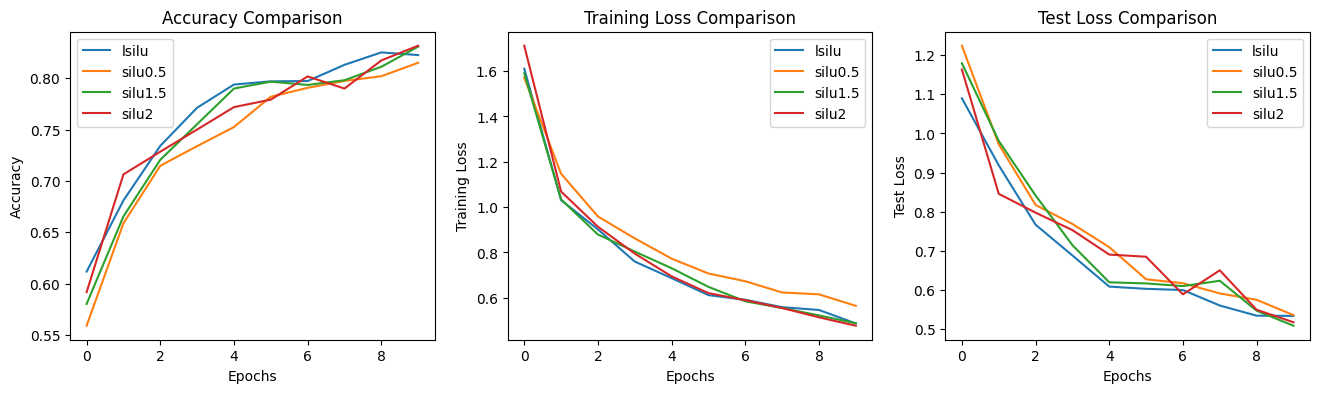

In [111]:
# 20 Layer Beta Comparison
current_activations = ["lsilu","silu0.5","silu1.5","silu2"]
dataset_list = load_datasets("resnet",20,current_activations)
graph_datasets(dataset_list,current_activations)


In [112]:
# Full results
compare_results(dataset_list, current_activations)

,Activation Function,Accuracy,Train Loss,Test Loss
0,lsilu,0.8226,0.487016,0.533784
1,silu0.5,0.8151,0.564699,0.535829
2,silu1.5,0.8308,0.487803,0.508667
3,silu2,0.8317,0.477034,0.517551
